## GLIMS region files download: Level 0 files

This script creates "Level 0" RGI files. These files are fetched directly from the GLIMS database, subsetted with a spatial bounding box around each region.

Level 0 files need to be updated to reflect new entries into the GLIMS database.

In [1]:
import geopandas as gpd
import shutil
from utils import mkdir
import numpy as np
import os

## RGI Region files 

In [2]:
# go down from rgi7_scripts/workflow/preprocessing
data_dir = '../../../rgi7_data/'

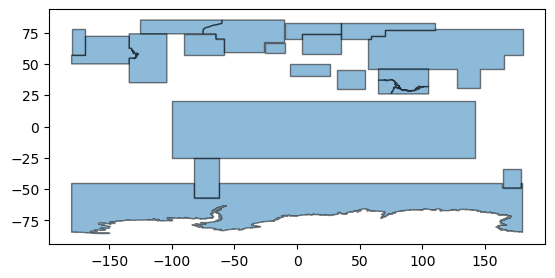

In [3]:
reg_file = os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions')
reg_f = gpd.read_file(reg_file)
reg_f.plot(alpha=0.5, edgecolor='k');

Region 10 has two boxes with glaciers in it:

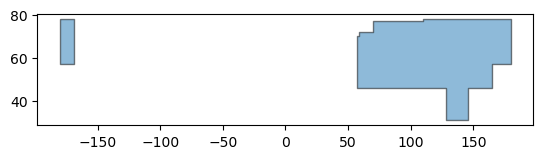

In [4]:
reg_f.loc[reg_f.o1region == '10'].plot(alpha=0.5, edgecolor='k');

## Download loop 

In [5]:
# If you want to (re-)download only selected regions
# reg_f_sel = reg_f.loc[reg_f.o1region.isin(['04', '19'])] 
reg_f_sel = reg_f
reg_f_sel

o1region                           full_name  \
0        01                              Alaska   
1        02              Western Canada and USA   
2        03                Arctic Canada, North   
3        04                Arctic Canada, South   
4        05                 Greenland Periphery   
5        06                             Iceland   
6        07              Svalbard and Jan Mayen   
7        08                         Scandinavia   
8        09                      Russian Arctic   
9        10                         Asia, North   
10       10                         Asia, North   
11       11                      Central Europe   
12       12            Caucasus and Middle East   
13       13                       Asia, Central   
14       14                    Asia, South West   
15       15                    Asia, South East   
16       16                       Low Latitudes   
17       17                      Southern Andes   
18       18                         New Zealand   
19       19  Subantarctic and Antarctic Islands   

                            long_code  \
0                           01_alaska   
1               02_western_canada_usa   
2              03_arctic_canada_north   
3              04_arctic_canada_south   
4              05_greenland_periphery   
5                          06_iceland   
6               07_svalbard_jan_mayen   
7                      08_scandinavia   
8                   09_russian_arctic   
9                       10_asia_north   
10                      10_asia_north   
11                  11_central_europe   
12            12_caucasus_middle_east   
13                    13_asia_central   
14                 14_asia_south_west   
15                 15_asia_south_east   
16                   16_low_latitudes   
17                  17_southern_andes   
18                     18_new_zealand   
19  19_subantarctic_antarctic_islands   

                                             geometry  
0   POLYGON ((-133.00000 54.50000, -134.00000 54.5...  
1   POLYGON ((-133.00000 54.50000, -132.00000 54.5...  
2   POLYGON ((-125.00000 74.00000, -125.00000 75.0...  
3   POLYGON ((-90.00000 74.00000, -89.00000 74.000...  
4   POLYGON ((-75.00000 77.00000, -74.73000 77.510...  
5   POLYGON ((-26.00000 59.00000, -26.00000 60.000...  
6   POLYGON ((-10.00000 70.00000, -10.00000 71.000...  
7   POLYGON ((4.00000 70.00000, 4.00000 71.00000, ...  
8   POLYGON ((35.00000 70.00000, 35.00000 71.00000...  
9   POLYGON ((-180.00000 78.00000, -179.00000 78.0...  
10  POLYGON ((128.00000 46.00000, 127.00000 46.000...  
11  POLYGON ((-6.00000 40.00000, -6.00000 41.00000...  
12  POLYGON ((32.00000 30.00000, 32.00000 32.00000...  
13  POLYGON ((80.00000 46.00000, 81.00000 46.00000...  
14  POLYGON ((75.40000 26.00000, 75.00000 26.00000...  
15  POLYGON ((75.40000 26.00000, 75.40000 27.00000...  
16  POLYGON ((-100.00000 -24.00000, -100.00000 -23...  
17  POLYGON ((-62.00000 -45.50000, -62.00000 -46.0...  
18  POLYGON ((179.00000 -49.00000, 178.00000 -49.0...  
19  POLYGON ((-179.00000 -45.50000, -178.00000 -45...

### With login 

Download date: May 23, 2023, 23H CEST

In [6]:
from glims_database_dump_wlogin import *

buffer = 0.5  # in degrees, buffer around the box
from_glims = mkdir(os.path.join(data_dir, 'l0_from_glims'))

for i, reg in reg_f_sel.iterrows():
    
    # Prepare bounds 
    x0, y0, x1, y1 = reg.geometry.bounds
    
    x0 = np.clip(x0 - buffer, -180., None)
    y0 = np.clip(y0 - buffer, -90., None)
    x1 = np.clip(x1 + buffer, None, 180.)
    y1 = np.clip(y1 + buffer, None, 90.)
    
    bounds = f' {x0:.2f},{y0:.2f},{x1:.2f},{y1:.2f}'
    print('')
    print('{}, {}. Bounds: {}'.format(reg.o1region, reg.full_name, bounds))
        
    # GLIMS request arguments
    p = setup_argument_parser()
    args = p.parse_args(['--mode', 'glims',
                         '--nunataks', 'GLIMS',  # We can't use RGI because it is buggy 
                         '--archive_type', 'tar',
                         '--download_type', 'extent',
                         '--clause', bounds,
                         '--netrc',
                         '--env', 'production'])
    
    urs_server = "urs.earthdata.nasa.gov"
    
    glims_servers = {
        "production": "www.glims.org/services",
        "blue": "blue.glims-services.apps.int.nsidc.org",
        "integration": "integration.glims.org/services",
        "qa": "qa.glims-services.apps.int.nsidc.org",
        "staging": "staging.glims-services.apps.int.nsidc.org",
    }
    server = glims_servers[args.env]

    if not args.noauth:
        # Get credentials from command-line or .netrc file
        credentials = get_credentials(args, urs_server)

        auth_session = get_authenticated_session(server, credentials[0], credentials[1])
        print("auth_session: ", auth_session)  # DEBUG

        if auth_session is None:
            print("Authentication failed.", file=sys.stderr)
            sys.exit(1)
    else:
        auth_session = get_noauth_session(server)

    filebasename = issue_order(server, auth_session, args)

    poll_readiness(
        server, auth_session, filebasename, args.protocol, period=2, tries=args.tries
    )  # returns when file is ready
    do_download(args, server, auth_session, filebasename)
    
    shutil.move(filebasename, os.path.join(from_glims, '{:02d}_RGI{:02d}.tgz'.format(i, int(reg['o1region']))))


01, Alaska. Bounds:  -180.00,49.50,-126.29,72.50
Authentication succeeded
NSIDC GLIMS could not authenticate with EDL
auth_session:  <requests.sessions.Session object at 0x7ff026e587f0>
Issued order to downloadprepare service using requests.get.  URL is:
https://www.glims.org/services/downloadprepare?download_type=extent&clause=-180.00%2C49.50%2C-126.29%2C72.50&archive_type=tar&file_format=shapefile&data_model=GLIMS&glims_v_rgi=glims&rgidate=2000-09-01
Status code:  200
Try #   1:  False.  File name:  glims_download_37624.tgz
Try #   2:  False.  File name:  glims_download_37624.tgz
Try #   3:  False.  File name:  glims_download_37624.tgz
Try #   4:  False.  File name:  glims_download_37624.tgz
Try #   5:  False.  File name:  glims_download_37624.tgz
Try #   6:  False.  File name:  glims_download_37624.tgz
Try #   7:  False.  File name:  glims_download_37624.tgz
Try #   8:  False.  File name:  glims_download_37624.tgz
Try #   9:  False.  File name:  glims_download_37624.tgz
Try #  10: 

In [7]:
print('Done!')

Done!


### Without login 

In [ ]:
from glims_database_dump import *

servers = {
        'production': 'www.glims.org/services',
        'blue': 'blue.glims-services.apps.int.nsidc.org',
        'integration': 'integration.glims-services.apps.int.nsidc.org',
        'qa': 'qa.glims-services.apps.int.nsidc.org',
        'staging': 'staging.glims-services.apps.int.nsidc.org',
        }

buffer = 0.5  # in degrees, buffer around the box
from_glims = mkdir(os.path.join(data_dir, 'l0_from_glims'))

for i, reg in reg_f_sel.iterrows():
    
    # Prepare bounds 
    x0, y0, x1, y1 = reg.geometry.bounds
    
    x0 = np.clip(x0 - buffer, -180., None)
    y0 = np.clip(y0 - buffer, -90., None)
    x1 = np.clip(x1 + buffer, None, 180.)
    y1 = np.clip(y1 + buffer, None, 90.)
    
    bounds = f' {x0:.2f},{y0:.2f},{x1:.2f},{y1:.2f}'
    print('')
    print('{}, {}. Bounds: {}'.format(reg.RGI_CODE, reg.FULL_NAME, bounds))
        
    # GLIMS request arguments
    p = setup_argument_parser()
    args = p.parse_args(['--mode', 'glims',
                         '--nunataks', 'GLIMS',  # We can't use RGI because it is buggy 
                         '--archive_type', 'tar',
                         '--download_type', 'extent',
                         '--clause', bounds])

    server = servers[args.env]

    filebasename = issue_order(server, args)
    poll_readiness(server, filebasename, period=2, tries=args.tries, protocol=args.protocol)    # returns when file is ready
    do_download(server, filebasename, args)
    
    shutil.move(filebasename, os.path.join(from_glims, '{:02d}_RGI{:02d}.tgz'.format(i, int(reg['RGI_CODE']))))